## Import libraries

In [135]:
import pandas as pnd
import numpy as np
from sklearn import preprocessing
from sklearn import neighbors, datasets
from sklearn import cross_validation
from sklearn.linear_model import SGDClassifier
from sklearn import svm
import operator

from sklearn.cross_validation import KFold

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import confusion_matrix

from sklearn import tree
import seaborn as sns

from IPython.display import Image

%matplotlib inline

## Main functions defining

In [136]:
# function for confusion matrix building
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    

def visualize_tree(tr, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        tree.export_graphviz(tr, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]

## 2.Problem Statement
A set of disease-predicting parameters {Ak} k=1,2..n is decided upon based on observed correlation with disease diagnosis (heart diseases in our case), where n is the number of such parameters.
We also have a set of N patients {xi} that have been diagnosed with heart disease or not, and the dataset consists of the {Ak(xi)} parameter readings. where {wk}k=1,2..n is a set of weights for each of the n disease-predicting parameters (to be determined by fitting the dataset to the model).
The models are aiming to predict the probability that a given patient x will be diagnosed as heart disease, and predict the weights of the features on finding the probability. When our data was a small data sets, then we hope that the model will fit the data without the risk of overfitting.  


## 3.Dataset Description
The dataset used in this project is part of a database contains 14 features from Cleveland Clinic Foundation for heart disease [1]. The dataset shows different levels of heart disease presence from 1 to 4 and 0 for the absence of the disease. Experiments with the Cleveland database have concentrated on simply attempting to distinguish presence (values 1, 2, 3, 4) from absence (value 0). We have 303 rows of people data with 13 continuous observation of different symptoms. 


In [137]:
# add the rows names
header_row = ['age','sex','chest_pain','blood pressure','serum_cholestoral','fasting_blood_sugar',\
               'electrocardiographic','max_heart_rate','induced_angina','ST_depression','slope','vessels','thal','diagnosis']

# read csv file with Cleveland heart diseases data
heart = pnd.read_csv('processed.cleveland.data.csv', names=header_row)
heart[:5]

,age,sex,chest_pain,blood pressure,serum_cholestoral,fasting_blood_sugar,electrocardiographic,max_heart_rate,induced_angina,ST_depression,slope,vessels,thal,diagnosis
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [138]:
len(heart)

303

#### As shown above, we have 303 rows of people data with 13 continous observation of different symptoms. 

## 4.Features Description
The table below, summarizes the features information:

| Feature  | Detail           | 
| ------------- |:-------------:| 
| Age      | Age in years | 
| Sex      | 1 for male; 0 for female    |  
| Chest pain type | Value1: typical angina. Value2: atypical angina. Value3: non-anginal pain. Vlaue4: asymptomatic|
| Resting blood pressure| In mm hg on admission to the hospital| 
| Serum cholesterol|In mg/dI|  
| Fasting blood sugar > 120 mg/dI|1 for true; 0 for false|  
| Resting electrocardiographic results|Value0: normal. Value1: having ST-T wave abnormality (T-wave inversions and/or ST elevation or depression of > 0.05 mV). Value2: showing probable or definite left ventricular hypertrophy by Estes’s criteria| 
|Maximum heart rate achieved| centered      |  
|Exercise-induced angina|1 for yes; 0 for no|  
|ST depression induced by exercise relative to rest|In mm Hg on admission to the hospital| 
|Number of major vessels| (0-3) colored by fluoroscopy|  
|The slope of the peak exercise ST segment|Value1: upsloping. Value2: flat. Value3: downsloping|  
|Thallium heart scan|3 for normal; 6 for fixed defect; 7 for reversible defect| 
|Diagnosis heart disease (angiographic disease)|Value0: no disease. Value1: heart disease|   

## 5.Data Exploration

In [139]:
# get statistics values
heart.describe()

,age,sex,chest_pain,blood pressure,serum_cholestoral,fasting_blood_sugar,electrocardiographic,max_heart_rate,induced_angina,ST_depression,slope,diagnosis
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,4.000000


In [140]:
# get number of people with symptom X_k
names_descr = dict()
categorical_columns = ["sex", "chest_pain", "fasting_blood_sugar", "electrocardiographic", "induced_angina", "slope", "vessels", \
                       "thal", "diagnosis"]
for c in categorical_columns:
    print  heart.groupby([c])["age"].count()

sex
0.0     97
1.0    206
Name: age, dtype: int64
chest_pain
1.0     23
2.0     50
3.0     86
4.0    144
Name: age, dtype: int64
fasting_blood_sugar
0.0    258
1.0     45
Name: age, dtype: int64
electrocardiographic
0.0    151
1.0      4
2.0    148
Name: age, dtype: int64
induced_angina
0.0    204
1.0     99
Name: age, dtype: int64
slope
1.0    142
2.0    140
3.0     21
Name: age, dtype: int64
vessels
0.0    176
1.0     65
2.0     38
3.0     20
?        4
Name: age, dtype: int64
thal
3.0    166
6.0     18
7.0    117
?        2
Name: age, dtype: int64
diagnosis
0    164
1     55
2     36
3     35
4     13
Name: age, dtype: int64


#### Here we can see how many people which symptom have

### 5.1 preprocess the data, to change the missing data into mean value, using simple mean imputation methods

In [141]:
# we have unknown values '?'
# change unrecognized value '?' into mean value through the column
for c in heart.columns[:-1]:
    heart[c] = heart[c].apply(lambda x: heart[heart[c]!='?'][c].astype(float).mean() if x == "?" else x)
    heart[c] = heart[c].astype(float)
    

### 5.2 Heart disease types discovering

In [142]:
# print the types of heart disease
set(heart.loc[:, "diagnosis"].values)

{0, 1, 2, 3, 4}

#### 0 - no disease
#### 1,2,3,4 - types of disease by severity in ascending

In [143]:
# let's calculate similarities between 1,2,3,4 levels 
# we will use euclidean distance 
vecs_1 = heart[heart["diagnosis"] == 1 ].median().values[:-2]
vecs_2 = heart[heart["diagnosis"] == 2 ].median().values[:-2]
vecs_3 = heart[heart["diagnosis"] == 3 ].median().values[:-2]
vecs_4 = heart[heart["diagnosis"] == 4 ].median().values[:-2]

In [144]:
vecs_1

array([  57. ,    1. ,    4. ,  130. ,  249. ,    0. ,    2. ,  150. ,
          0. ,    0.8,    2. ,    1. ])

In [145]:
print "Similarity between type 1 and type 2 is ", np.linalg.norm(vecs_1-vecs_2)
print "Similarity between type 1 and type 3 is ", np.linalg.norm(vecs_1-vecs_3)
print "Similarity between type 1 and type 4 is ", np.linalg.norm(vecs_1-vecs_4)
print "Similarity between type 2 and type 3 is ", np.linalg.norm(vecs_2-vecs_3)
print "Similarity between type 2 and type 4 is ", np.linalg.norm(vecs_2-vecs_4)
print "Similarity between type 3 and type 4 is ", np.linalg.norm(vecs_3-vecs_4)

Similarity between type 1 and type 2 is  10.3831594421
Similarity between type 1 and type 3 is  21.2837966538
Similarity between type 1 and type 4 is  29.7639043138
Similarity between type 2 and type 3 is  13.0770791846
Similarity between type 2 and type 4 is  27.9399355762
Similarity between type 3 and type 4 is  29.5210094678


In [146]:
sim = {"(1,2)": np.linalg.norm(vecs_1-vecs_2), \
       "(1,3)": np.linalg.norm(vecs_1-vecs_3),\
       "(1,4)": np.linalg.norm(vecs_1-vecs_4),\
       "(2,3)": np.linalg.norm(vecs_2-vecs_3),\
       "(2,4)": np.linalg.norm(vecs_2-vecs_4),\
       "(3,4)": np.linalg.norm(vecs_3-vecs_4)    
      }

In [147]:
# sort by the closest types
sorted_sim = sorted(sim.items(), key=operator.itemgetter(1))
sorted_sim

[('(1,2)', 10.383159442096611),
 ('(2,3)', 13.077079184588582),
 ('(1,3)', 21.283796653792763),
 ('(2,4)', 27.939935576160515),
 ('(3,4)', 29.521009467834936),
 ('(1,4)', 29.76390431378249)]

#### We can see that the mild forms of disease are more similar than 4 type of heart disease and others

In [148]:
# we can compare the types of heart disease by using values of each feature separately 

heart_d = heart[heart["diagnosis"] >= 1 ]
heart_d[:5]

,age,sex,chest_pain,blood pressure,serum_cholestoral,fasting_blood_sugar,electrocardiographic,max_heart_rate,induced_angina,ST_depression,slope,vessels,thal,diagnosis
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
6,62.0,0.0,4.0,140.0,268.0,0.0,2.0,160.0,0.0,3.6,3.0,2.0,3.0,3
8,63.0,1.0,4.0,130.0,254.0,0.0,2.0,147.0,0.0,1.4,2.0,1.0,7.0,2
9,53.0,1.0,4.0,140.0,203.0,1.0,2.0,155.0,1.0,3.1,3.0,0.0,7.0,1


### 5.3 Let's find the ranges of each feature by disease type 

#### 5.3.1 Age

In [149]:
print "Minimum age to Maximum age per disease type"

heart_d.groupby(["diagnosis", ])["age"].min().astype(str) + ', ' +  heart_d.groupby(["diagnosis", ])["age"].max().astype(str)

Minimum age to Maximum age per disease type


diagnosis
1    35.0, 70.0
2    42.0, 69.0
3    39.0, 70.0
4    38.0, 77.0
Name: age, dtype: object

In [150]:
print "Mean age per disease type"
heart_d.groupby(["diagnosis", ])["age"].mean()

Mean age per disease type


diagnosis
1    55.381818
2    58.027778
3    56.000000
4    59.692308
Name: age, dtype: float64

#### We can see that heart disease with type 3 can be present in lower age then type 2

#### 5.3.2 Sex

In [151]:
print "Count each sex per heart disease type"
heart_d.groupby(["diagnosis", "sex"])["age"].count()

Count each sex per heart disease type


diagnosis  sex
1          0.0     9
           1.0    46
2          0.0     7
           1.0    29
3          0.0     7
           1.0    28
4          0.0     2
           1.0    11
Name: age, dtype: int64

#### We can see that heart disease all types can be present in men with higher probability than in women

#### 5.3.3 chest_pain

In [152]:
print "Count each chest pain value per heart disease type"
heart_d.groupby(["diagnosis", "chest_pain"])["age"].count()

Count each chest pain value per heart disease type


diagnosis  chest_pain
1          1.0            5
           2.0            6
           3.0            9
           4.0           35
2          1.0            1
           2.0            1
           3.0            4
           4.0           30
3          2.0            2
           3.0            4
           4.0           29
4          1.0            1
           3.0            1
           4.0           11
Name: age, dtype: int64

#### The people with chest pain = 4 often have heart disease.  

#### 5.3.4 blood pressure

In [153]:
print "Minimum blood pressure to Maximum  blood pressure per disease type"

heart_d.groupby(["diagnosis"])["blood pressure"].min().astype(str) + ', ' +  heart_d.groupby(["diagnosis"])["blood pressure"].max().astype(str)

Minimum blood pressure to Maximum  blood pressure per disease type


diagnosis
1    108.0, 192.0
2    100.0, 180.0
3    100.0, 200.0
4    112.0, 165.0
Name: blood pressure, dtype: object

In [154]:
print "Mean blood pressure per disease type"
heart_d.groupby(["diagnosis", ])["blood pressure"].mean()

Mean blood pressure per disease type


diagnosis
1    133.254545
2    134.194444
3    135.457143
4    138.769231
Name: blood pressure, dtype: float64

#### As bigger is mean blood pressure as higher is type of heart disease

#### 5.3.5 serum_cholestoral

In [155]:
print "Minimum serum_cholestoral to Maximum serum_cholestoral per disease type"

heart_d.groupby(["diagnosis"])["serum_cholestoral"].min().astype(str) + ', ' +  heart_d.groupby(["diagnosis"])["serum_cholestoral"].max().astype(str)

Minimum serum_cholestoral to Maximum serum_cholestoral per disease type


diagnosis
1    149.0, 335.0
2    169.0, 409.0
3    131.0, 353.0
4    166.0, 407.0
Name: serum_cholestoral, dtype: object

In [156]:
print "Mean serum_cholestoral per disease type"
heart_d.groupby(["diagnosis", ])["serum_cholestoral"].mean()

Mean serum_cholestoral per disease type


diagnosis
1    249.109091
2    259.277778
3    246.457143
4    253.384615
Name: serum_cholestoral, dtype: float64

#### 5.3.6 fasting_blood_sugar

In [157]:
print "Count each fasting_blood_sugar per heart disease type"
heart_d.groupby(["diagnosis", "fasting_blood_sugar"])["age"].count()

Count each fasting_blood_sugar per heart disease type


diagnosis  fasting_blood_sugar
1          0.0                    51
           1.0                     4
2          0.0                    27
           1.0                     9
3          0.0                    27
           1.0                     8
4          0.0                    12
           1.0                     1
Name: age, dtype: int64

#### 5.3.7 electrocardiographic results

In [158]:
print "Count each electrocardiographic per heart disease type"
heart_d.groupby(["diagnosis", "electrocardiographic"])["age"].count()

Count each electrocardiographic per heart disease type


diagnosis  electrocardiographic
1          0.0                     23
           2.0                     32
2          0.0                     19
           1.0                      1
           2.0                     16
3          0.0                     12
           1.0                      1
           2.0                     22
4          0.0                      2
           1.0                      1
           2.0                     10
Name: age, dtype: int64

#### 5.3.8 max_heart_rate

In [159]:
print "Minimum max_heart_rate to Maximum max_heart_rate per disease type"

heart_d.groupby(["diagnosis"])["max_heart_rate"].min().astype(str) + ', ' +  heart_d.groupby(["diagnosis"])["max_heart_rate"].max().astype(str)

Minimum max_heart_rate to Maximum max_heart_rate per disease type


diagnosis
1     88.0, 195.0
2     71.0, 170.0
3     90.0, 173.0
4    114.0, 182.0
Name: max_heart_rate, dtype: object

In [160]:
print "Mean max_heart_rate per disease type"
heart_d.groupby(["diagnosis", ])["max_heart_rate"].mean()

Mean max_heart_rate per disease type


diagnosis
1    145.927273
2    135.583333
3    132.057143
4    140.615385
Name: max_heart_rate, dtype: float64

#### 5.3.9 induced_angina

In [161]:
print "Count  induced_angina per heart disease type"
heart_d.groupby(["diagnosis", "induced_angina"])["age"].count()

Count  induced_angina per heart disease type


diagnosis  induced_angina
1          0.0               30
           1.0               25
2          0.0               14
           1.0               22
3          0.0               12
           1.0               23
4          0.0                7
           1.0                6
Name: age, dtype: int64

#### 5.3.10 ST_depression

In [162]:
print "Count  mean ST_depression per heart disease type"
heart_d.groupby(["diagnosis"])["ST_depression"].mean()

Count  mean ST_depression per heart disease type


diagnosis
1    1.005455
2    1.780556
3    1.962857
4    2.361538
Name: ST_depression, dtype: float64

In [163]:
heart_d[:2]

,age,sex,chest_pain,blood pressure,serum_cholestoral,fasting_blood_sugar,electrocardiographic,max_heart_rate,induced_angina,ST_depression,slope,vessels,thal,diagnosis
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1


#### 5.3.11 slope

In [164]:
print "Count slope per heart disease type"
heart_d.groupby(["diagnosis", "slope"])["age"].count()

Count slope per heart disease type


diagnosis  slope
1          1.0      22
           2.0      31
           3.0       2
2          1.0       7
           2.0      26
           3.0       3
3          1.0       6
           2.0      24
           3.0       5
4          1.0       1
           2.0      10
           3.0       2
Name: age, dtype: int64

#### 5.3.12 vessels

In [165]:
print "Count  mean vessels per heart disease type"
heart_d.groupby(["diagnosis"])["vessels"].mean()

Count  mean vessels per heart disease type


diagnosis
1    0.739495
2    1.222222
3    1.457143
4    1.692308
Name: vessels, dtype: float64

#### 5.3.13 thal

In [166]:
print "Count  mean thal per heart disease type"
heart_d.groupby(["diagnosis"])["thal"].mean()

Count  mean thal per heart disease type


diagnosis
1    5.345455
2    5.992617
3    6.285714
4    6.230769
Name: thal, dtype: float64

### We can consider that the person with 

#### age > 38
#### man
#### with chest pain = 4
#### blood pressure > 112
#### serum_cholestoral > 166
#### fasting_blood_sugar = 0
#### electrocardiographic = 2
#### max_heart_rate > 114
#### ST_depression about 2
#### slope >=2
#### vessels about 1.6
#### thal more than 6

### is the most likely have 4 type of the heart disease

## 6 Data preprocessing

### 6.1 map dependent variable y = "diagnosis" into binary label

In [175]:
# if "diagnosis" == 0, member does not have disease A - we put 0
# if "diagnosis" >= 1, member possess the disease A - we put 1
heart.loc[:, "diag_int"] = heart.loc[:, "diagnosis"].apply(lambda x: 1 if x >= 1 else 0)

### 6.2 normalize the data

In [174]:
# create the normalizer and fit it 
preprocessing.Normalizer().fit_transform(heart)

array([[ 0.19741527,  0.00313358,  0.00313358, ...,  0.01880145,
         0.        ,  0.        ],
       [ 0.19057465,  0.0028444 ,  0.01137759, ...,  0.00853319,
         0.0056888 ,  0.0028444 ],
       [ 0.22578159,  0.00336987,  0.0134795 , ...,  0.02358912,
         0.00336987,  0.00336987],
       ..., 
       [ 0.25334975,  0.00444473,  0.01777893, ...,  0.03111313,
         0.0133342 ,  0.00444473],
       [ 0.17495449,  0.        ,  0.00613875, ...,  0.00920813,
         0.00306938,  0.00306938],
       [ 0.13346695,  0.00351229,  0.01053686, ...,  0.01053686,
         0.        ,  0.        ]])

## 7  Constructing the sample set

In [176]:
# split dataset into train and test
heart_train, heart_test, goal_train, goal_test = cross_validation.train_test_split(heart.loc[:,'age':'thal'], \
                                                 heart.loc[:,'diag_int'], test_size=0.33, random_state=0)  

## 8 Attribute sets decomposing

In [177]:
# calculate the correlation between features

corr = heart.corr()
heart.corr()

,age,sex,chest_pain,blood pressure,serum_cholestoral,fasting_blood_sugar,electrocardiographic,max_heart_rate,induced_angina,ST_depression,slope,vessels,thal,diagnosis,diag_int
age,1.000000,-0.097542,0.104139,0.284946,0.208950,0.118530,0.148868,-0.393806,0.091661,0.203805,0.161770,0.359489,0.127368,0.222853,0.223120
sex,-0.097542,1.000000,0.010084,-0.064456,-0.199915,0.047862,0.021647,-0.048663,0.146201,0.102173,0.037533,0.092891,0.379300,0.224469,0.276816
chest_pain,0.104139,0.010084,1.000000,-0.036077,0.072319,-0.039975,0.067505,-0.334422,0.384060,0.202277,0.152050,0.232332,0.264895,0.407075,0.414446
blood pressure,0.284946,-0.064456,-0.036077,1.000000,0.130120,0.175340,0.146560,-0.045351,0.064762,0.189171,0.117382,0.098707,0.133534,0.157754,0.150825
serum_cholestoral,0.208950,-0.199915,0.072319,0.130120,1.000000,0.009841,0.171043,-0.003432,0.061310,0.046564,-0.004062,0.118525,0.014190,0.070909,0.085164
fasting_blood_sugar,0.118530,0.047862,-0.039975,0.175340,0.009841,1.000000,0.069564,-0.007854,0.025665,0.005747,0.059894,0.143967,0.070658,0.059186,0.025264
electrocardiographic,0.148868,0.021647,0.067505,0.146560,0.171043,0.069564,1.000000,-0.083389,0.084867,0.114133,0.133946,0.127487,0.024449,0.183696,0.169202
max_heart_rate,-0.393806,-0.048663,-0.334422,-0.045351,-0.003432,-0.007854,-0.083389,1.000000,-0.378103,-0.343085,-0.385601,-0.263408,-0.278530,-0.415040,-0.417167
induced_angina,0.091661,0.146201,0.384060,0.064762,0.061310,0.025665,0.084867,-0.378103,1.000000,0.288223,0.257748,0.144722,0.328291,0.397057,0.431894
ST_depression,0.203805,0.102173,0.202277,0.189171,0.046564,0.005747,0.114133,-0.343085,0.288223,1.000000,0.577537,0.294558,0.340549,0.504092,0.424510


In [178]:
#build heatmap

cmap = sns.diverging_palette(250, 10, n=3, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,age,sex,chest_pain,blood pressure,serum_cholestoral,fasting_blood_sugar,electrocardiographic,max_heart_rate,induced_angina,ST_depression,slope,vessels,thal,diagnosis,diag_int
age,1,-0.098,0.1,0.28,0.21,0.12,0.15,-0.39,0.092,0.2,0.16,0.36,0.13,0.22,0.22
sex,-0.098,1,0.01,-0.064,-0.2,0.048,0.022,-0.049,0.15,0.1,0.038,0.093,0.38,0.22,0.28
chest_pain,0.1,0.01,1,-0.036,0.072,-0.04,0.068,-0.33,0.38,0.2,0.15,0.23,0.26,0.41,0.41
blood pressure,0.28,-0.064,-0.036,1,0.13,0.18,0.15,-0.045,0.065,0.19,0.12,0.099,0.13,0.16,0.15
serum_cholestoral,0.21,-0.2,0.072,0.13,1,0.0098,0.17,-0.0034,0.061,0.047,-0.0041,0.12,0.014,0.071,0.085
fasting_blood_sugar,0.12,0.048,-0.04,0.18,0.0098,1,0.07,-0.0079,0.026,0.0057,0.06,0.14,0.071,0.059,0.025
electrocardiographic,0.15,0.022,0.068,0.15,0.17,0.07,1,-0.083,0.085,0.11,0.13,0.13,0.024,0.18,0.17
max_heart_rate,-0.39,-0.049,-0.33,-0.045,-0.0034,-0.0079,-0.083,1,-0.38,-0.34,-0.39,-0.26,-0.28,-0.42,-0.42
induced_angina,0.092,0.15,0.38,0.065,0.061,0.026,0.085,-0.38,1,0.29,0.26,0.14,0.33,0.4,0.43
ST_depression,0.2,0.1,0.2,0.19,0.047,0.0057,0.11,-0.34,0.29,1,0.58,0.29,0.34,0.5,0.42


## 9 Exploratory Visualization

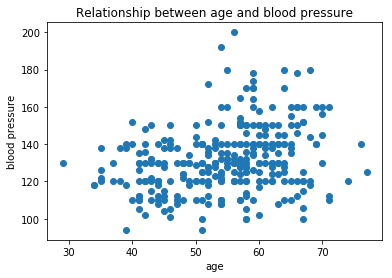

In [180]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.xlabel("age")
plt.ylabel("blood pressure")

# define title
plt.title("Relationship between age and blood pressure")

# plot
plt.scatter(heart['age'], heart['blood pressure'])
plt.show()

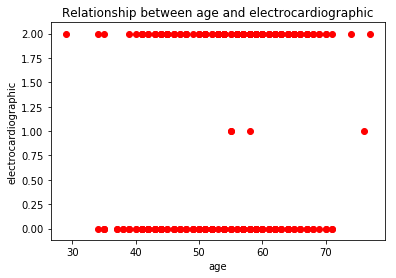

In [181]:
plt.xlabel("age")
plt.ylabel("electrocardiographic")

# define title
plt.title("Relationship between age and electrocardiographic")

# plot
plt.scatter(heart['age'], heart['electrocardiographic'], color = 'red')
plt.show()

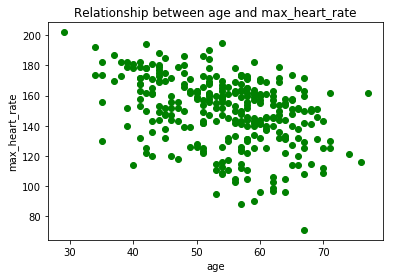

In [182]:
plt.xlabel("age")
plt.ylabel("max_heart_rate")

# define title
plt.title("Relationship between age and max_heart_rate")

# plot
plt.scatter(heart['age'], heart['max_heart_rate'], color = 'green')
plt.show()

## 10 correlation search

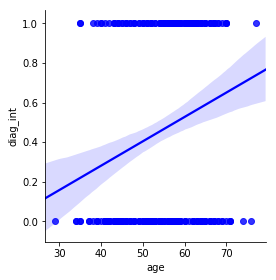

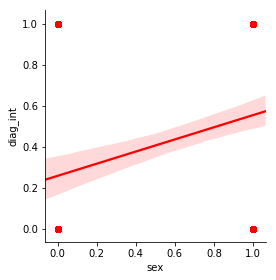

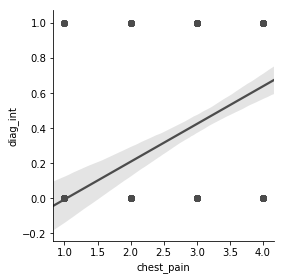

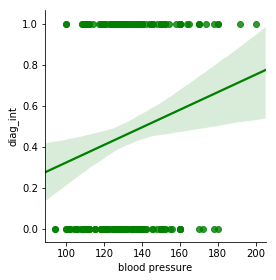

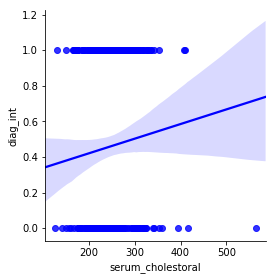

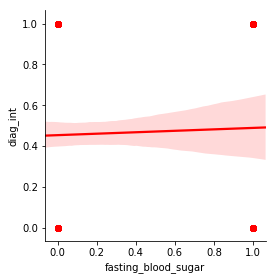

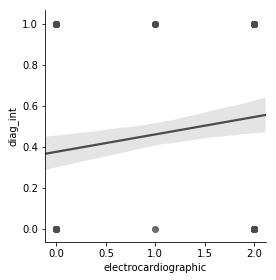

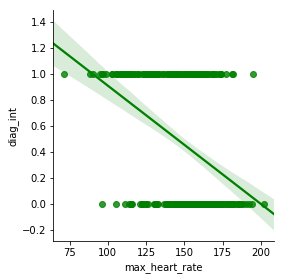

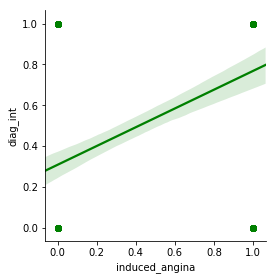

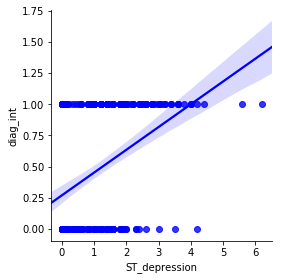

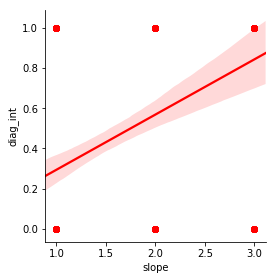

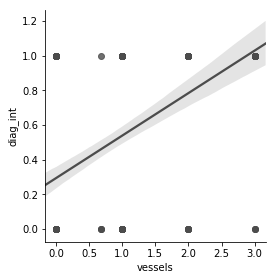

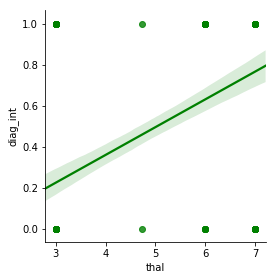

In [183]:
# search by the correlation between dependent variable and each feature

df = heart
g1 = sns.PairGrid(df, y_vars=["diag_int"], x_vars=["age"], size=4)
g1.map(sns.regplot, color="blue")

g2 = sns.PairGrid(df, y_vars=["diag_int"], x_vars=["sex"], size=4)
g2.map(sns.regplot, color="red")

g = sns.PairGrid(df, y_vars=["diag_int"], x_vars=["chest_pain"], size=4)
g.map(sns.regplot, color="0.3")

gg = sns.PairGrid(df, y_vars=["diag_int"], x_vars=["blood pressure"], size=4)
gg.map(sns.regplot, color="green")

g1 = sns.PairGrid(df, y_vars=["diag_int"], x_vars=["serum_cholestoral"], size=4)
g1.map(sns.regplot, color="blue")

g2 = sns.PairGrid(df, y_vars=["diag_int"], x_vars=["fasting_blood_sugar"], size=4)
g2.map(sns.regplot, color="red")

g = sns.PairGrid(df, y_vars=["diag_int"], x_vars=["electrocardiographic"], size=4)
g.map(sns.regplot, color="0.3")

gg = sns.PairGrid(df, y_vars=["diag_int"], x_vars=["max_heart_rate"], size=4)
gg.map(sns.regplot, color="green")

gg = sns.PairGrid(df, y_vars=["diag_int"], x_vars=["induced_angina"], size=4)
gg.map(sns.regplot, color="green")

g1 = sns.PairGrid(df, y_vars=["diag_int"], x_vars=["ST_depression"], size=4)
g1.map(sns.regplot, color="blue")

g2 = sns.PairGrid(df, y_vars=["diag_int"], x_vars=["slope"], size=4)
g2.map(sns.regplot, color="red")

g = sns.PairGrid(df, y_vars=["diag_int"], x_vars=["vessels"], size=4)
g.map(sns.regplot, color="0.3")

gg = sns.PairGrid(df, y_vars=["diag_int"], x_vars=["thal"], size=4)
gg.map(sns.regplot, color="green")

#### From the charts above we can see that there are no correlation between each pair of symptoms. So, we should use them all for model building

## 11. Build training set and estimate the LSS parameters (Model 1)

In [186]:
# add parameters for grid search
loss = ["hinge", "log"]
penalty = ["l1", "l2"]
alpha = [0.1, 0.05, 0.01]
n_iter = [500, 1000]

# build the models with different parameters and select the best combination for the highest Accuracy
best_score = 0
best_param = (0,0,0,0)
for l in loss:
    for p in penalty:
        for a in alpha:
            for n in n_iter:
                print("Parameters for model", (l,p,a,n))
                lss = SGDClassifier(loss=l, penalty=p, alpha=a, n_iter=n)
                lss.fit(heart_train, goal_train)
                print("Linear regression SGD Cross-Validation scores:")
                scores = cross_validation.cross_val_score(lss, heart.loc[:,'age':'thal'], heart.loc[:,'diag_int'], cv=10)
                print scores
                print("Mean Linear regression SGD Cross-Validation score = ", np.mean(scores))
                
                if np.mean(scores) > best_score:
                    best_score = np.mean(scores)
                    best_param = (l,p,a,n)
                    
    
print("The best parameters for model are ", best_param)
print("The Cross-Validation score = ", best_score)


('Parameters for model', ('hinge', 'l1', 0.1, 500))
Linear regression SGD Cross-Validation scores:
[ 0.80645161  0.83870968  0.87096774  0.87096774  0.73333333  0.7
  0.66666667  0.7         0.66666667  0.79310345]
('Mean Linear regression SGD Cross-Validation score = ', 0.76468668891360769)
('Parameters for model', ('hinge', 'l1', 0.1, 1000))
Linear regression SGD Cross-Validation scores:


/Users/abdullahalrhmoun/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/abdullahalrhmoun/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[ 0.77419355  0.83870968  0.80645161  0.90322581  0.8         0.6
  0.66666667  0.7         0.76666667  0.79310345]
('Mean Linear regression SGD Cross-Validation score = ', 0.76490174267704858)
('Parameters for model', ('hinge', 'l1', 0.05, 500))
Linear regression SGD Cross-Validation scores:
[ 0.83870968  0.87096774  0.70967742  0.90322581  0.8         0.7         0.7
  0.8         0.73333333  0.82758621]
('Mean Linear regression SGD Cross-Validation score = ', 0.78835001853911746)
('Parameters for model', ('hinge', 'l1', 0.05, 1000))
Linear regression SGD Cross-Validation scores:


/Users/abdullahalrhmoun/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/abdullahalrhmoun/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[ 0.87096774  0.77419355  0.87096774  0.87096774  0.8         0.6
  0.73333333  0.8         0.8         0.86206897]
('Mean Linear regression SGD Cross-Validation score = ', 0.79824990730441225)
('Parameters for model', ('hinge', 'l1', 0.01, 500))
Linear regression SGD Cross-Validation scores:
[ 0.87096774  0.83870968  0.80645161  0.90322581  0.8         0.76666667
  0.66666667  0.8         0.8         0.86206897]
('Mean Linear regression SGD Cross-Validation score = ', 0.81147571375602523)
('Parameters for model', ('hinge', 'l1', 0.01, 1000))
Linear regression SGD Cross-Validation scores:


/Users/abdullahalrhmoun/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/abdullahalrhmoun/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[ 0.87096774  0.83870968  0.80645161  0.90322581  0.8         0.66666667
  0.73333333  0.86666667  0.76666667  0.89655172]
('Mean Linear regression SGD Cross-Validation score = ', 0.8149239896180942)
('Parameters for model', ('hinge', 'l2', 0.1, 500))
Linear regression SGD Cross-Validation scores:
[ 0.70967742  0.74193548  0.58064516  0.87096774  0.6         0.7
  0.46666667  0.73333333  0.66666667  0.79310345]
('Mean Linear regression SGD Cross-Validation score = ', 0.68629959213941416)
('Parameters for model', ('hinge', 'l2', 0.1, 1000))
Linear regression SGD Cross-Validation scores:


/Users/abdullahalrhmoun/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/abdullahalrhmoun/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[ 0.74193548  0.80645161  0.5483871   0.80645161  0.86666667  0.66666667
  0.8         0.83333333  0.73333333  0.79310345]
('Mean Linear regression SGD Cross-Validation score = ', 0.75963292547274752)
('Parameters for model', ('hinge', 'l2', 0.05, 500))
Linear regression SGD Cross-Validation scores:
[ 0.80645161  0.51612903  0.4516129   0.90322581  0.53333333  0.76666667
  0.73333333  0.83333333  0.73333333  0.44827586]
('Mean Linear regression SGD Cross-Validation score = ', 0.67256952169076745)
('Parameters for model', ('hinge', 'l2', 0.05, 1000))
Linear regression SGD Cross-Validation scores:


/Users/abdullahalrhmoun/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/abdullahalrhmoun/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[ 0.87096774  0.77419355  0.77419355  0.5483871   0.7         0.8
  0.76666667  0.46666667  0.66666667  0.48275862]
('Mean Linear regression SGD Cross-Validation score = ', 0.68505005561735266)
('Parameters for model', ('hinge', 'l2', 0.01, 500))
Linear regression SGD Cross-Validation scores:
[ 0.4516129   0.87096774  0.70967742  0.67741935  0.63333333  0.76666667
  0.63333333  0.8         0.73333333  0.65517241]
('Mean Linear regression SGD Cross-Validation score = ', 0.69315164998146084)
('Parameters for model', ('hinge', 'l2', 0.01, 1000))
Linear regression SGD Cross-Validation scores:


/Users/abdullahalrhmoun/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/abdullahalrhmoun/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[ 0.80645161  0.74193548  0.48387097  0.70967742  0.83333333  0.73333333
  0.7         0.83333333  0.66666667  0.79310345]
('Mean Linear regression SGD Cross-Validation score = ', 0.73017055988134971)
('Parameters for model', ('log', 'l1', 0.1, 500))
Linear regression SGD Cross-Validation scores:


/Users/abdullahalrhmoun/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[ 0.77419355  0.87096774  0.83870968  0.87096774  0.8         0.7         0.7
  0.76666667  0.73333333  0.79310345]
('Mean Linear regression SGD Cross-Validation score = ', 0.78479421579532815)
('Parameters for model', ('log', 'l1', 0.1, 1000))
Linear regression SGD Cross-Validation scores:


/Users/abdullahalrhmoun/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[ 0.80645161  0.77419355  0.77419355  0.87096774  0.8         0.7
  0.66666667  0.8         0.73333333  0.79310345]
('Mean Linear regression SGD Cross-Validation score = ', 0.77189098998887651)
('Parameters for model', ('log', 'l1', 0.05, 500))
Linear regression SGD Cross-Validation scores:


/Users/abdullahalrhmoun/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[ 0.80645161  0.77419355  0.83870968  0.87096774  0.8         0.63333333
  0.66666667  0.7         0.73333333  0.79310345]
('Mean Linear regression SGD Cross-Validation score = ', 0.76167593622543561)
('Parameters for model', ('log', 'l1', 0.05, 1000))
Linear regression SGD Cross-Validation scores:


/Users/abdullahalrhmoun/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[ 0.83870968  0.83870968  0.80645161  0.87096774  0.83333333  0.7
  0.73333333  0.83333333  0.8         0.79310345]
('Mean Linear regression SGD Cross-Validation score = ', 0.80479421579532795)
('Parameters for model', ('log', 'l1', 0.01, 500))
Linear regression SGD Cross-Validation scores:


/Users/abdullahalrhmoun/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[ 0.80645161  0.83870968  0.83870968  0.93548387  0.8         0.56666667
  0.73333333  0.83333333  0.73333333  0.79310345]
('Mean Linear regression SGD Cross-Validation score = ', 0.78791249536522057)
('Parameters for model', ('log', 'l1', 0.01, 1000))
Linear regression SGD Cross-Validation scores:


/Users/abdullahalrhmoun/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[ 0.83870968  0.83870968  0.80645161  0.93548387  0.8         0.66666667
  0.73333333  0.76666667  0.73333333  0.89655172]
('Mean Linear regression SGD Cross-Validation score = ', 0.80159065628476078)
('Parameters for model', ('log', 'l2', 0.1, 500))
Linear regression SGD Cross-Validation scores:


/Users/abdullahalrhmoun/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[ 0.80645161  0.80645161  0.80645161  0.74193548  0.9         0.76666667
  0.46666667  0.8         0.7         0.62068966]
('Mean Linear regression SGD Cross-Validation score = ', 0.74153133110863922)
('Parameters for model', ('log', 'l2', 0.1, 1000))
Linear regression SGD Cross-Validation scores:


/Users/abdullahalrhmoun/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[ 0.67741935  0.77419355  0.83870968  0.90322581  0.8         0.76666667
  0.66666667  0.86666667  0.76666667  0.79310345]
('Mean Linear regression SGD Cross-Validation score = ', 0.78533185020393026)
('Parameters for model', ('log', 'l2', 0.05, 500))
Linear regression SGD Cross-Validation scores:


/Users/abdullahalrhmoun/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[ 0.61290323  0.83870968  0.4516129   0.83870968  0.76666667  0.7         0.7
  0.86666667  0.63333333  0.68965517]
('Mean Linear regression SGD Cross-Validation score = ', 0.70982573229514279)
('Parameters for model', ('log', 'l2', 0.05, 1000))
Linear regression SGD Cross-Validation scores:


/Users/abdullahalrhmoun/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[ 0.87096774  0.80645161  0.58064516  0.70967742  0.5         0.76666667
  0.8         0.6         0.76666667  0.48275862]
('Mean Linear regression SGD Cross-Validation score = ', 0.68838338895068596)
('Parameters for model', ('log', 'l2', 0.01, 500))
Linear regression SGD Cross-Validation scores:
[ 0.80645161  0.83870968  0.83870968  0.74193548  0.83333333  0.66666667
  0.7         0.46666667  0.7         0.79310345]

/Users/abdullahalrhmoun/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)



('Mean Linear regression SGD Cross-Validation score = ', 0.73855765665554318)
('Parameters for model', ('log', 'l2', 0.01, 1000))
Linear regression SGD Cross-Validation scores:
[ 0.90322581  0.87096774  0.58064516  0.4516129   0.8         0.56666667
  0.46666667  0.86666667  0.73333333  0.82758621]
('Mean Linear regression SGD Cross-Validation score = ', 0.70673711531331107)
('The best parameters for model are ', ('hinge', 'l1', 0.01, 1000))
('The Cross-Validation score = ', 0.8149239896180942)


/Users/abdullahalrhmoun/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


#### We can see that the best parameters are  ('log', 'l1', 0.01, 1000)

In [187]:
# develop the model with the best parameters

lss_best = SGDClassifier(alpha=0.05, fit_intercept=True, loss='log', n_iter=1000,
penalty='l1')
lss_best.fit(heart_train, goal_train)
print("Linear regression SGD Test score:")
print(lss_best.score(heart_test, goal_test))   

Linear regression SGD Test score:
0.78


/Users/abdullahalrhmoun/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


## 12 Model evaluation


Confusion matrix, without normalization
[[43  6]
 [16 35]]


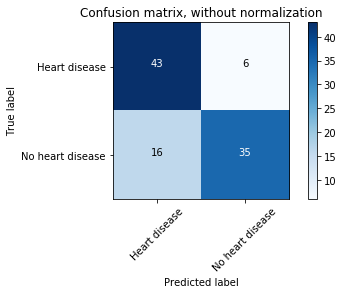

In [189]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(goal_test, lss_best.predict(heart_test))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Heart disease", "No heart disease"],
                      title='Confusion matrix, without normalization')
plt.show()

## 13 performance metrics

-**Accuracy**: is the ratio between the number of correct predictions and total number of predications. 

$acc = \frac{TP + TN}{TP + TN + FP + FN}$

-**Precision**: is the ratio between the number of correct positives and the number of true positives plus the number of false positives.

$Precision (p) = \frac{TP}{TP + FP}$

-**Recall**: is the ratio between the number of correct positives and the number of true positives plus the number of false negatives.

$recall = \frac{TP}{TP + FN}$

-**F-score**: is known as the harmonic mean of precision and recall.

$acc = \frac{1}{\frac{1}{2}(\frac{1}{p}+\frac{1}{r})} = \frac{2pr}{p+r}$

-Problem characteristics in context of our case study:

TP = True positive (has heart disease).
TN = True negative (has no heart disease).
FP = False positive (has no heart disease)
FN = False negative (has heart disease)


In [191]:
#get the performance metrics
scores = ['accuracy', 'f1', 'precision', 'recall']

metrics = {score: cross_validation.cross_val_score(lss_best,heart_test, goal_test, scoring=score).mean() for score in scores}

metrics

{'accuracy': 0.80005941770647659,
 'f1': 0.78518518518518521,
 'precision': 0.85925925925925928,
 'recall': 0.80392156862745112}

## 14 Probability for test data calculation

In [192]:
# predict heart disease for test dataset
y_pred_proba = lss_best.predict_proba(heart_test)
y_pred_proba = [x[1] for x in y_pred_proba]
for i in y_pred_proba[:10]:
    print i

1.48844518146e-100
1.0
0.000291100261712
1.25879994771e-50
7.73485429252e-48
1.0
1.0
1.0
1.0
2.97835976133e-50


In [193]:
# predict heart disease for test dataset
y_pred = lss_best.predict(heart_test)
y_pred[:25]

array([0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0])

In [194]:
test_df = pnd.DataFrame(heart_test, columns = header_row[:-1])

test_df.loc[:, "Disease_probability"] = [x[1] for x in lss_best.predict_proba(heart_test)]
test_df.to_excel("disease_probability.xlsx", index = False)
test_df[:5]

,age,sex,chest_pain,blood pressure,serum_cholestoral,fasting_blood_sugar,electrocardiographic,max_heart_rate,induced_angina,ST_depression,slope,vessels,thal,Disease_probability
225,34.0,0.0,2.0,118.0,210.0,0.0,0.0,192.0,0.0,0.7,1.0,0.0,3.0,1.488445e-100
152,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,1.000000e+00
228,54.0,1.0,4.0,110.0,206.0,0.0,2.0,108.0,1.0,0.0,2.0,1.0,3.0,2.911003e-04
201,64.0,0.0,4.0,180.0,325.0,0.0,0.0,154.0,1.0,0.0,1.0,0.0,3.0,1.258800e-50
52,44.0,1.0,4.0,112.0,290.0,0.0,2.0,153.0,0.0,0.0,1.0,1.0,3.0,7.734854e-48


## 15 Features coefficients printing

In [195]:
# print weights for each X_k from the built  LSS model
w = lss_best.coef_[0]
a = -w[0] / w[1]
print "Weight Coefficients"
coeff_df = pnd.DataFrame(columns = ['X_k', 'coeff'])
for c in xrange(len(heart.loc[:,'age':'thal'].columns)):
    coeff_df.loc[len(coeff_df)] = [heart.loc[:,'age':'thal'].columns[c], w[c]]
    
coeff_df

Weight Coefficients


/Users/abdullahalrhmoun/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


,X_k,coeff
0,age,0.000000
1,sex,0.000000
2,chest_pain,13.436168
3,blood pressure,0.000000
4,serum_cholestoral,0.093615
5,fasting_blood_sugar,0.000000
6,electrocardiographic,0.000000
7,max_heart_rate,-2.175121
8,induced_angina,6.132622
9,ST_depression,16.376522


## 16 Model 2: Decision tree

In [196]:
# build Decision tree model
best_score_dt = 0

criterion = ['gini', 'entropy']

for c in criterion:             

            clf = tree.DecisionTreeClassifier(criterion=c)

            clf.fit(heart_train, goal_train)
            print("Decision tree Cross-Validation scores:")
            scores = cross_validation.cross_val_score(clf, heart.loc[:,'age':'thal'], heart.loc[:,'diag_int'], cv=10)
            print scores
            print("Mean Decision tree Cross-Validation score = ", np.mean(scores))

            if np.mean(scores) > best_score_dt:
                best_score_dt = np.mean(scores)
                best_param_dt = (c)
                    
    
print("The best parameters for model are ", best_param_dt)
print("The Cross-Validation score = ", best_score_dt)

Decision tree Cross-Validation scores:
[ 0.81  0.84  0.9   0.77  0.73  0.73  0.67  0.77  0.73  0.76]
('Mean Decision tree Cross-Validation score = ', 0.77145346681497962)
Decision tree Cross-Validation scores:
[ 0.87  0.84  0.84  0.84  0.7   0.7   0.57  0.77  0.77  0.72]
('Mean Decision tree Cross-Validation score = ', 0.76112347052280316)
('The best parameters for model are ', 'gini')
('The Cross-Validation score = ', 0.77145346681497962)


In [197]:
# develop the model with the best parameters

lss_best_dt = tree.DecisionTreeClassifier(criterion = 'entropy')
lss_best_dt.fit(heart_train, goal_train)
print("Decision tree Test score:")
print(lss_best_dt.score(heart_test, goal_test))

Decision tree Test score:
0.74


Confusion matrix, without normalization
[[41  8]
 [18 33]]


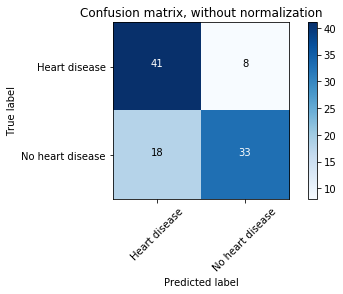

In [198]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(goal_test, lss_best_dt.predict(heart_test))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Heart disease", "No heart disease"],
                      title='Confusion matrix, without normalization')
plt.show()

In [199]:
visualize_tree(lss_best_dt, heart.loc[:,'age':'thal'].columns)

/Users/abdullahalrhmoun/anaconda2/lib/python2.7/site-packages/sklearn/tree/export.py:399: DeprecationWarning: out_file can be set to None starting from 0.18. This will be the default in 0.20.
  DeprecationWarning)


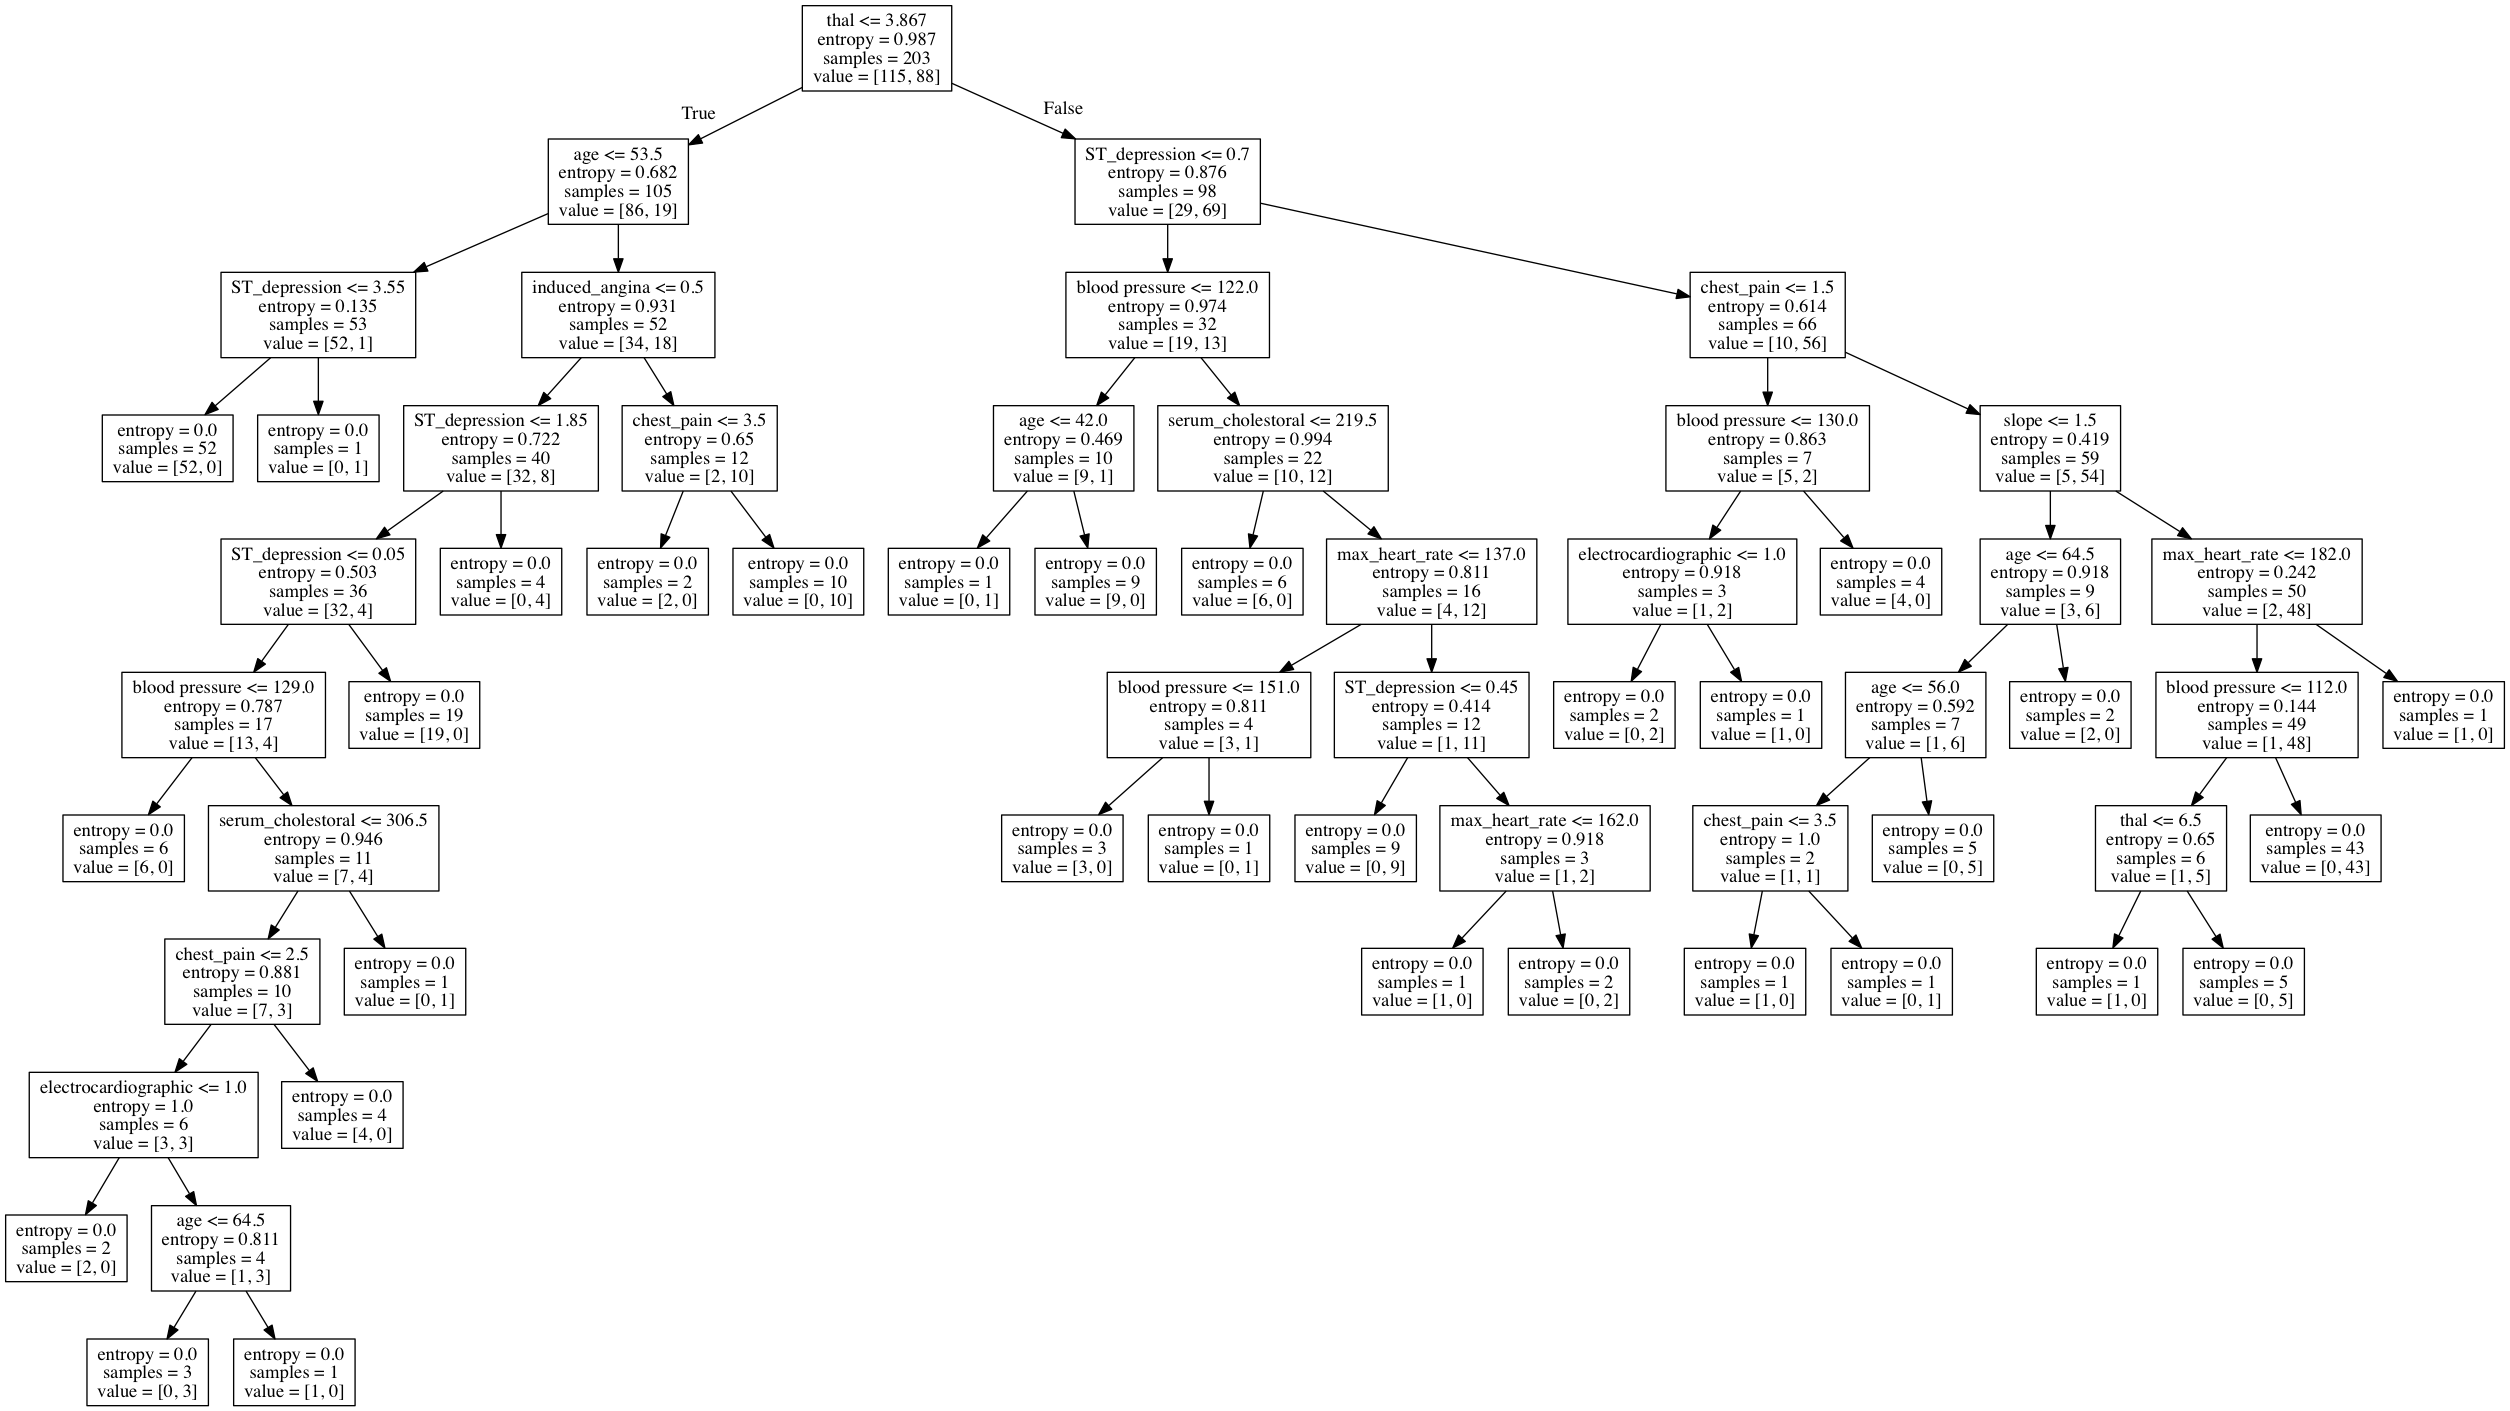

In [200]:
from IPython.display import Image  
import pydotplus 
dot_data = tree.export_graphviz(lss_best_dt)
graph = pydotplus.graphviz.graph_from_dot_file("dt.dot")
graph.write_pdf("dt.pdf")
Image(graph.create_png())

## 17 Return probabilities for each feature X_s

In [201]:
# the probability of reaching each node for each X_k by using Decision trees

# print weights for each X_k from the built  LSS model
w = lss_best_dt.feature_importances_

prob_df = pnd.DataFrame(columns = ['X_k', 'P(X_k)'])
for c in xrange(len(heart.loc[:,'age':'thal'].columns)):
    prob_df.loc[len(prob_df)] = [heart.loc[:,'age':'thal'].columns[c], w[c]]
    
prob_df

,X_k,P(X_k)
0,age,0.151090
1,sex,0.000000
2,chest_pain,0.111615
3,blood pressure,0.086219
4,serum_cholestoral,0.052283
5,fasting_blood_sugar,0.000000
6,electrocardiographic,0.027494
7,max_heart_rate,0.062856
8,induced_angina,0.058448
9,ST_depression,0.194875


In [202]:
print "Sum of dependent probabilities = " , prob_df["P(X_k)"].sum()

Sum of dependent probabilities =  1.0


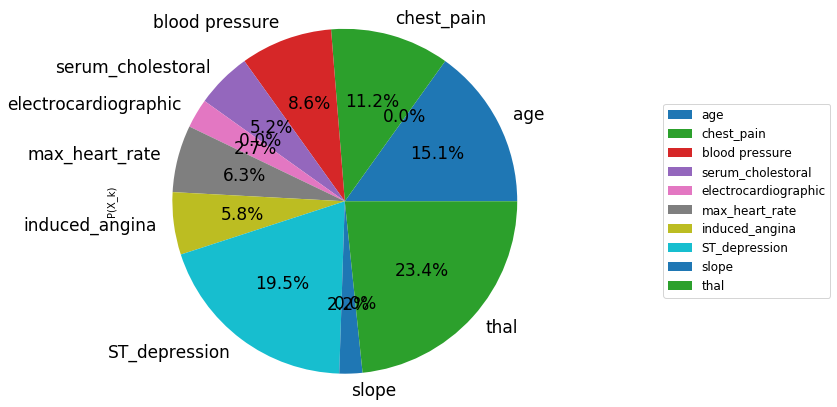

In [231]:
prob_df.index = prob_df["X_k"].values
group_names = prob_df["X_k"].values
#counts = pnd.Series(prob_df["X_k"].values,prob_df["P(X_k)"].values)

#explode = (0, 0.1, 0.2, 0.25, 0.3, 0.35, 0)
#colors =  ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', 'violet', 'pink', 'orange', 'red']

prob_df.plot(kind='pie', fontsize=17, figsize=(8, 7), autopct='%1.1f%%', subplots=True)
plt.axis('equal')
plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5), prop={'size':12})
plt.show()


# Develop a module to combine all the above modules in a sequential manner


In [204]:
def data_parsing(path):
    header_row = ['age','sex','chest_pain','blood pressure','serum_cholestoral','fasting_blood_sugar',\
               'electrocardiographic','max_heart_rate','induced_angina','ST_depression','slope','vessels','thal','diagnosis']

    # read csv file with Cleveland heart diseases data
    heart = pnd.read_csv(path, names=header_row)
    
    # we have unknown values '?'
    # change unrecognized value '?' into mean value through the column
    for c in heart.columns[:-1]:
        heart[c] = heart[c].apply(lambda x: heart[heart[c]!='?'][c].astype(float).mean() if x == "?" else x)
        heart[c] = heart[c].astype(float)
        
    
    # map dependent variable y = "diagnosis" into binary label
    # if "diagnosis" == 0, member does not have disease A - we put 0
    # if "diagnosis" >= 1, member possess the disease A - we put 1

    heart.loc[:, "diag_int"] = heart.loc[:, "diagnosis"].apply(lambda x: 1 if x >= 1 else 0)
    
    return heart


def subset_decomposition(data):
    # split dataset into train and test
    heart_train, heart_test, goal_train, goal_test = cross_validation.train_test_split(data.loc[:,'age':'thal'], \
                                                     data.loc[:,'diag_int'], test_size=0.33, random_state=0)
    return heart_train, heart_test, goal_train, goal_test

def model_building(heart):
    # add parameters for grid search
    loss = ["hinge", "log"]
    penalty = ["l1", "l2"]
    alpha = [0.05, 0.01]
    n_iter = [500, 1000]
    heart_train, heart_test, goal_train, goal_test = subset_decomposition(heart)
    # build the models with different parameters and select the best combination for the highest Accuracy
    best_score = 0
    best_param = (0,0,0,0)
    for l in loss:
        for p in penalty:
            for a in alpha:
                for n in n_iter:
                    #print("Parameters for model", (l,p,a,n))
                    lss = SGDClassifier(loss=l, penalty=p, alpha=a, n_iter=n)
                    lss.fit(heart_train, goal_train)
                    #print("Linear regression SGD Cross-Validation scores:")
                    scores = cross_validation.cross_val_score(lss, heart.loc[:,'age':'thal'], heart.loc[:,'diag_int'], cv=10)
                    #print scores
                    #print("Mean Linear regression SGD Cross-Validation score = ", np.mean(scores))

                    if np.mean(scores) > best_score:
                        best_score = np.mean(scores)
                        best_param = (l,p,a,n)


    print("The best parameters for model are ", best_param)
    print("The Cross-Validation score = ", best_score)

    # develop the model with the best parameters

    lss_best = SGDClassifier(loss='log', penalty='l1', alpha=0.05, n_iter=1000)
    lss_best.fit(heart_train, goal_train)
    print("Linear regression SGD Test score:")
    print(lss_best.score(heart_test, goal_test))  
    
   
    return lss_best

def self_prediction(heart_test, model):    
    # predict heart disease for test dataset
    y_pred_proba = model.predict_proba(heart_test)
    y_pred_proba = [x[1] for x in y_pred_proba]
    for i in y_pred_proba[:10]:
        print i
    return y_pred_proba



    
if __name__ == '__main__':
    heart = data_parsing('processed.cleveland.data.csv')
    model = model_building(heart)

/Users/abdullahalrhmoun/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/abdullahalrhmoun/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/abdullahalrhmoun/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/abdullahalrhmoun/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


('The best parameters for model are ', ('log', 'l1', 0.01, 1000))
('The Cross-Validation score = ', 0.82460140897293288)
Linear regression SGD Test score:
0.8


/Users/abdullahalrhmoun/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
